# Produces Tables for different datasets and fill tables with content imported from fasta

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 21 08:50:35 2022

@author: friederike
"""


import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
import itertools
import math
import numpy as np
#choose clusters from the sequence similarity network to use as classes of ferredoxins
clusterlist =[1,2,3,4,5,6,7,8,9,12,14]
# fill in names of files here!
foldername_set_input="Output"
foldernameinput="whole_dataset_neighbouring_threshold=20/Alignments"
foldernameoutput=foldernameinput.split("/")[0]+"/"+"Output"
fragments=("begin","sbr1","sbr2","core","end","fes1","fes2")
filenamescomplete=[]
include_parts=True
include_sequence_motifs=True
indicator=""
if include_parts==True:
    indicator+="_include_parts_"
if include_sequence_motifs==False:
    indicator+="_without_sequence_motifs_"
for cluster in clusterlist:
    filenames_per_cluster=[]  
    for fragment in fragments:
        filename_input=foldernameinput+"/whole_dataset_threshold_20_"+str(cluster)+" Alignment_consens_"+fragment+".fasta"
        filenames_per_cluster.append(filename_input)
    filenamescomplete.append(filenames_per_cluster)
filename_permutations=foldername_set_input+"/permutations.txt"
fragments=("begin","sbr1","sbr2","core","end","fes1","fes2")
with open(filename_permutations, 'r') as file:
    permutations = [line.rstrip('\n') for line in file]

def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""
def easysequence (sequence):
    #creates a string out of the sequence file, that only states if AA is acidic (a), basic (b), polar (p), neutral/unpolar (n),aromatic (r),Cystein (s) or a Prolin (t)
    seqstr=str(sequence)
    seqlist=list(seqstr)
    easylist=[]
    for i in seqlist:
        if i == 'E' or i== 'D':           
            easylist=easylist+['a']
        if i == 'K' or i=='R' or i=='H':      
            easylist=easylist+['b']
        if i == 'S' or i=='T' or i=='N' or i=='Q':
            easylist=easylist+['p']
        if i == 'F' or i=='Y' or i=='W':
            easylist=easylist+['r']
        if i == 'C':
            easylist=easylist+['s']
        if i == 'P':
            easylist=easylist+['t']
        if i == 'G' or i=='A' or i=='V' or i=='L' or i=='I' or i=='M':
            easylist=easylist+['n']
    seperator=''
    easysequence=seperator.join(easylist)
    return easysequence
def calculate_charge(sequence):
    AACharge = {"C":-.045,"D":-.999,  "E":-.998,"H":.091,"K":1,"R":1,"Y":-.001}
    charge = -0.002
    seqstr=str(sequence)
    seqlist=list(seqstr)
    for aa in seqlist:
        if aa in AACharge:
            charge += AACharge[aa]
    return charge

def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z        

# creates tables
tablep450n=pd.DataFrame()
for counter,listfiles in enumerate(filenamescomplete):
        table=pd.DataFrame()
        for counter2, file in enumerate(listfiles):
            tempframe=pd.DataFrame()
            fragment=fragments[counter2]
            easy_sequences=[]
            aa_sequences=[]
            for seq_record in SeqIO.parse(file, "fasta"):
                seq_record.seq=Seq(str(seq_record.seq).replace('-', ''))
                easy_sequences.append(easysequence(str(seq_record.seq)))
                aa_sequences.append(seq_record.seq) 
            for index_sequence,easy_sequence in  enumerate(easy_sequences):       
                new_row={}
                #add "motif" features
                if include_sequence_motifs==True:
                    for motiv in permutations:
                        #defines column of table where to add
                        name=motiv+fragment
                        new_row =merge_two_dicts(new_row,{name:easy_sequence.count(motiv)})
                #add general features
                acidic=fragment+"acidic"
                new_row =merge_two_dicts(new_row,{acidic:(easy_sequence.count("a")/len(easy_sequence)+1)})
                acidic_absolute=fragment+"acidic absolute"
                new_row =merge_two_dicts(new_row,{acidic_absolute:(easy_sequence.count("a"))})
                charge=fragment+"charge"
                new_row =merge_two_dicts(new_row,{charge:calculate_charge(aa_sequences[index_sequence])})
                basic=fragment+"basic"
                basic_absolute=fragment+"basic absolute"
                new_row =merge_two_dicts(new_row,{basic:(easy_sequence.count("b")/len(easy_sequence)+1)})
                new_row =merge_two_dicts(new_row,{basic_absolute:(easy_sequence.count("b"))})
                if include_parts==True:
                    if fragment in fragments:
                        how_many_parts=3
                        each_part_length = math.ceil(len(easy_sequence)/how_many_parts)
                        iterator = [iter(easy_sequence)] * each_part_length
                        parts = list(itertools.zip_longest(*iterator, fillvalue='X'))
                        for i in range (0,len(parts)):
                                part=fragment+"acidic"+ str(i)
                                par=parts[i]
                                new_row =merge_two_dicts(new_row,{part:(par.count("a")/(len(par)+1))})
                                part=fragment+"basic"+ str(i)
                                par=parts[i]
                                new_row =merge_two_dicts(new_row,{part:(par.count("b")/(len(par)+1))})
                        if len(parts)<3:
                            for dif in range ((len(parts)+1),4):
                                part=fragment+"acidic"+ str(dif)
                                new_row =merge_two_dicts(new_row,{part:0})
                                part=fragment+"basic"+ str(dif)
                                new_row =merge_two_dicts(new_row,{part:0})
                tempframe = tempframe.append(new_row, ignore_index=True)
            table=pd.concat((table,tempframe),axis=1)
        table['target']=counter+1
        tablep450n=pd.concat((tablep450n,table),axis=0)
chargerows=[]
acidicrows=[]
basicrows=[]
absacidicrows=[]
absbasicrows=[]
for fragment in fragments:
    chargerows.append(str(fragment)+"charge")
    acidicrows.append(str(fragment)+"acidic")
    basicrows.append(str(fragment)+"basic")
    absacidicrows.append(str(fragment)+"acidic absolute")
    absbasicrows.append(str(fragment)+"basic absolute")
print(tablep450n["target"])
tablep450n['complete charge']=tablep450n[chargerows].sum(axis=1)
tablep450n['mean acidic']=tablep450n[acidicrows].mean(axis=1)  
tablep450n['mean basic']=tablep450n[basicrows].mean(axis=1)  
tablep450n['absolute acidic']=tablep450n[absacidicrows].sum(axis=1)  
tablep450n['absolute basic']=tablep450n[absbasicrows].sum(axis=1)
tablep450n = tablep450n.replace('nan', np.nan).fillna(0)
tablep450n.to_csv(foldernameoutput+"/"+foldernameoutput.split("/")[0]+"_feature_matrix_without_duplicates"+indicator+".csv", index=False) 

0      1
1      1
2      1
3      1
4      1
      ..
26    11
27    11
28    11
29    11
30    11
Name: target, Length: 850, dtype: int64


# Machine learning 

Max depth: 15
              precision    recall  f1-score   support

           1       1.00      0.97      0.99       118
           2       0.83      1.00      0.91        75
           3       1.00      0.88      0.94        17
           4       1.00      1.00      1.00        74
           5       1.00      1.00      1.00        24
           6       1.00      0.86      0.92         7
           7       1.00      0.96      0.98        23
           8       0.94      1.00      0.97        16
           9       1.00      0.97      0.99        38
          10       1.00      0.81      0.90        16
          11       1.00      0.71      0.83        17

    accuracy                           0.96       425
   macro avg       0.98      0.92      0.95       425
weighted avg       0.97      0.96      0.96       425

 
Tree Score: 0.8658823529411764
Tree Balanced Accuracy Score: 0.8407905017058449
Crossvalidation scores tree: [0.89 0.88 0.88 0.92 0.87]
 
Forest Score: 0.9623529411764706


/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


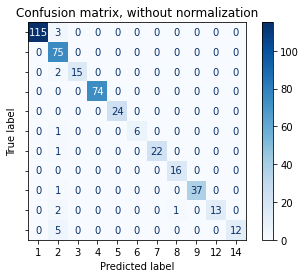

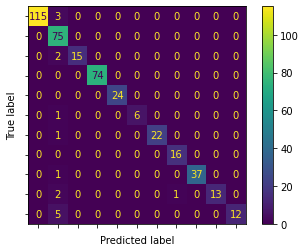

<Figure size 1080x576 with 0 Axes>

/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


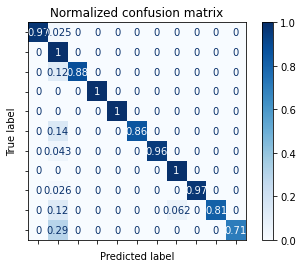

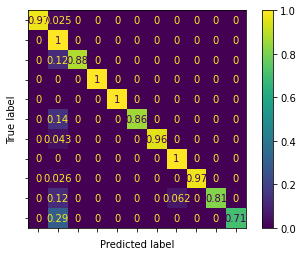

<Figure size 1080x576 with 0 Axes>

In [16]:
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report

ros = RandomOverSampler(random_state=0)
clusterlist =[1,2,3,4,5,6,7,8,9,12,14]

#define max depth of decision tree
maxd=15
# fill in names of files here!
pathcompletetable="whole_dataset_neighbouring_threshold=20/Output/whole_dataset_neighbouring_threshold=20_feature_matrix_without_duplicates_include_parts_.csv"
foldernameoutput="whole_dataset_neighbouring_threshold=20/Output/"
completetable=pd.read_csv(pathcompletetable)
completetable = completetable.sample(frac = 1) 

# define target and features
#if you want wo run this multiple times, enable the following line! (otherwise "prediciton"will be used as a feature)
#completetable.drop(columns=['prediction'],inplace=True)
x_data = completetable.loc[:, completetable.columns != 'target' ]
y_data = completetable['target']

# split into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data ,test_size = 0.5, shuffle=True)

#resample to balance 
x_train, y_train = ros.fit_resample(x_train, y_train)

print ("Max depth:", maxd)
# use decision tree and random forest classifier for predictions 
forest=RandomForestClassifier(max_depth=maxd,min_samples_leaf=1,class_weight="balanced")
tree= DecisionTreeClassifier(max_depth=maxd,class_weight="balanced",min_samples_leaf=1)
extratree=ExtraTreesClassifier(max_depth=maxd,min_samples_leaf=1,class_weight="balanced")

# Train Decision Tree Classifer
tree = tree.fit(x_train,y_train)
forest = forest.fit(x_train,y_train)
extratree = extratree.fit(x_train,y_train)

#predict for test set
test_predict=tree.predict(x_test)
test_predictf=forest.predict(x_test)
test_predictx=extratree.predict(x_test)

#predict for complete set
y_pred = forest.predict(x_data)
completetable['prediction']=y_pred

#calculate accuracy
scores = cross_val_score(tree, x_data, y_data, cv=5, scoring='f1_macro')
scoresf = cross_val_score(forest, x_data, y_data, cv=5, scoring='f1_macro')
scoresx = cross_val_score(extratree, x_data, y_data, cv=5, scoring='f1_macro')
baccu=balanced_accuracy_score(y_test, test_predict)
baccuf=balanced_accuracy_score(y_test, test_predictf)
baccux=balanced_accuracy_score(y_test, test_predictx)

# creating a confusion matrix 
cm = multilabel_confusion_matrix(y_test, test_predictf)
print(classification_report(y_test,test_predictf))

#print all the scores
print (" ")
print("Tree Score:", tree.score(x_test, y_test))
print ("Tree Balanced Accuracy Score:",baccu)
print ("Crossvalidation scores tree:",scores)
print (" ")
print("Forest Score:", forest.score(x_test, y_test))
print ("Forest Balanced Accuracy Score:",baccuf)
print ("Crossvalidation scores forest:",scoresf)
print (" ")
print("Extra tree score:", extratree.score(x_test, y_test))
print ("Extra tree Balanced Accuracy Score:",baccux)
print ("Crossvalidation scores Extra tree:",scoresx)

np.set_printoptions(precision=2)
class_names=map(str, clusterlist)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(forest, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.plot()
    for labels in disp.text_.ravel():
        labels.set_fontsize(10)
    plt.figure(figsize=(15,8))
    plt.savefig(("confusionmatrix"+str(normalize)+".png"), format="png")
    plt.show()

#save trained classifier
filename = foldernameoutput+'/decisiontreeclassifieronlynext.sav'
pickle.dump(tree, open(filename, 'wb'))
filename = foldernameoutput+'/forestclassifieronlynext.sav'
pickle.dump(forest, open(filename, 'wb'))
pathcompletetable=pathcompletetable[:-3]+"_withprediciton.csv"
completetable.to_csv(pathcompletetable, index=False)

In [ ]:
# Print confusion matrices

425 425


/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


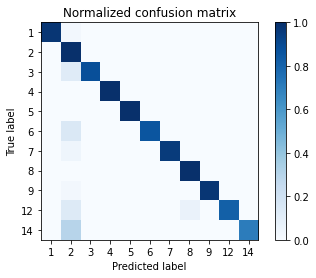

/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

In [17]:
np.set_printoptions(precision=1)
class_names=map(str, clusterlist)
# Plot non-normalized confusion matrix
titles_options = [
                  ("Normalized confusion matrix", 'true'),("Confusion matrix, without normalization", None),]

fig, ax = plt.subplots() 
print (len(x_test),len(y_test))
for title, normalize in titles_options:
    disp = plot_confusion_matrix(forest, x_test, y_test,
                                 display_labels=clusterlist,
                                 cmap=plt.cm.Blues,
                                 include_values=False,
                                 
                                 normalize=normalize,ax=ax)
    disp.ax_.set_title(title)
    plt.savefig(("confusionmatrix"+str(normalize)+".png"), format="png")
    plt.show()
    

# One vs all classifier for differentiated metrics

/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


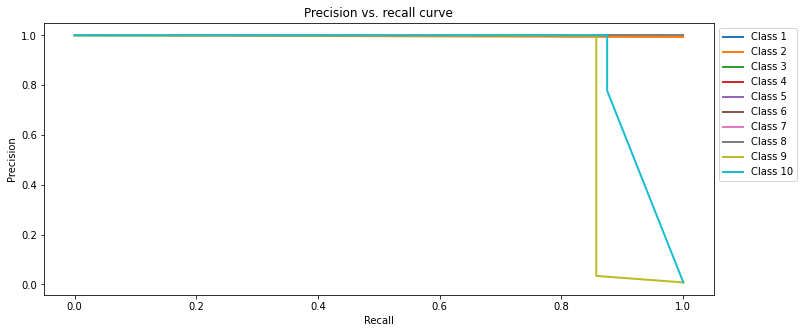

/home/friederike/anaconda3/envs/frida/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


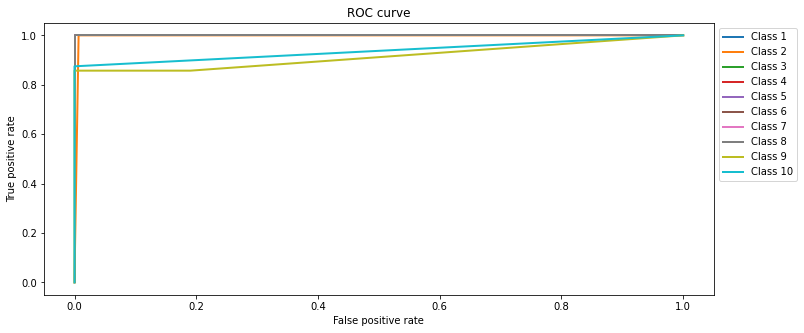

In [5]:
import sklearn
import pandas as pd
import pickle
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
ros = RandomOverSampler(random_state=0)

#define max depth of decision tree
maxd=20
pathcompletetable="whole_dataset_neighbouring_threshold_35/whole_dataset_threshold_35_neighbouring_feature_matrix.csv"
foldernameoutput="whole_dataset_neighbouring_threshold_35/"
completetable=pd.read_csv(pathcompletetable)
completetable = completetable.sample(frac = 1) 

# define target and features
#if you want wo run this multiple times, enable the following line! (otherwise "prediciton"will be used as a feature)
#completetable.drop(columns=['prediction'],inplace=True)
x_data = completetable.loc[:, completetable.columns != 'target' ]
y_data = completetable['target']
n_classes = len(set(y_data))
Y = label_binarize(y_data, classes=[*range(n_classes)])

X_train, X_test, y_train, y_test = train_test_split(x_data,
                                                    Y,
                                                    random_state = 42)
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=50,
                             max_depth=3,
                             random_state=0))
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

# precision recall curve
precision = dict()
recall = dict()
plt.figure(figsize=(12,5))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(i+1))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("Precision vs. recall curve")
plt.savefig(("precisionrecallferredoxinscurve.png"), format="png")
plt.show()

# roc curve
fpr = dict()
tpr = dict()
plt.figure(figsize=(12,5))
for i in range(0,n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {}'.format(i+1))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("ROC curve")
plt.savefig(("ROC curve.png"), format="png")
plt.show()

# Analyse Tree

adapted from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

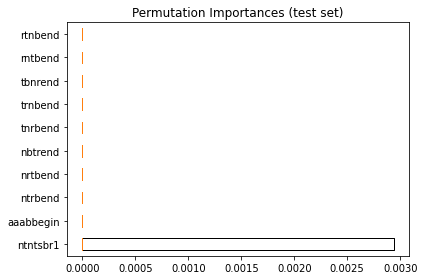

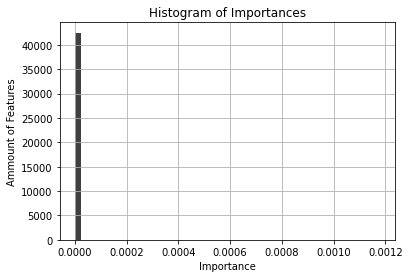

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#how many rows?
rows=10
#fill in correct file names
foldernameoutput="whole_dataset_neighbouring_threshold=20/Output/"
filename = foldernameoutput+'/forestclassifieronlynext.sav'
filenameout=foldernameoutput+"/_include_parts_motifs_importances.txt"
fname=foldernameoutput+"/_include_parts_motifs_importances.pdf"
hisname=foldernameoutput+"/_include_parts_motifs_importanceshis.png"
pathcompletetable="whole_dataset_neighbouring_threshold=20/Output/whole_dataset_neighbouring_threshold=20_feature_matrix_without_duplicates_include_parts_._withprediciton.csv"

completetable=pd.read_csv(pathcompletetable)
completetable.drop(columns=['prediction'],inplace=True)
x_data = completetable.loc[:, completetable.columns != 'target' ]
y_data = completetable['target']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data ,test_size = 0.4, shuffle=True)
forest = pickle.load(open(filename, 'rb')) 
feature_names=x_data.columns
result = permutation_importance(forest, x_test, y_test, n_repeats=10,
                               random_state=42, n_jobs=2)
sorted_idx =(-result.importances_mean).argsort()
labels=x_test.columns[sorted_idx]
sorted_idx_fetched=sorted_idx[0:rows]
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx_fetched].T,
           vert=False,labels= labels[0:rows])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

with open(filenameout, 'w') as f:
    for s in sorted_idx: 
        f.write(str(x_test.columns[s])+","+ str(result.importances_mean[s]) +'\n')
fig.savefig(fname)

# the histogram of the data
n, bins, patches = plt.hist(result.importances_mean[sorted_idx], 50, density=True, facecolor='k', alpha=0.75)
plt.xlabel('Importance')
plt.ylabel('Ammount of Features')
plt.title('Histogram of Importances')
plt.grid(True)
plt.show()
plt.savefig(hisname)

# Get all different amino acid motifs from easysequence motif and create prosite motif from them

In [ ]:
def split(word):
    return [char for char in word]
motiflist=['rsnn', 'rata', 'bbpb', 'tnnn', 'snna', 'bbbp', 'trnn', 'ptrn', 'rabn',
       'bsnn']
for i in motiflist:
    motif=i
    motiflist=split(motif)
    prosite=""
    for i in motiflist:
        if i=="a":
            prosite=prosite+"[E/D]"
        if i=="p":
            prosite=prosite+"[S/T/N/Q]"
        if i=="b":
            prosite=prosite+"[K/R/H]"
        if i=="r":
            prosite=prosite+"[F/Y/W]"
        if i=="s":
            prosite=prosite+"C"
        if i=="t":
            prosite=prosite+"P"
        if i=="n":
            prosite=prosite+"[G/A/V/L/I/M]"
    print (motif, prosite)

# Examination of single Sequence

In this cell, sequences need to be alligned and precut at 92,192,275, and 395 and additionally at 54-66 and 375-392 of the referrence protein cytochrome P450 51  from Mycobacterium tuberculosis H2102 GenBank: KBE51585.1

# Examine new data

In [2]:
import Bio
import pandas as pd
from Bio import SeqIO
from Bio import pairwise2
from Bio.Seq import Seq
import re
import pickle
import math
import sys
import itertools
import sklearn
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn import svm
import numpy as np
include_parts= False
# fill in names of files here!
foldernameoutput="Output"
name_testsequence="Fasta/Ferredoxinsirinpak/sirinterpene.fasta"
filename_permutations=foldernameoutput+"/permutations.txt"
classifier=foldernameoutput+'/forestclassifieronlynext.sav'
forest = pickle.load(open(classifier, 'rb')) 
filename_index=foldernameoutput+"/index.txt"
with open(filename_index, 'r') as f:
    index = [line.rstrip('\n') for line in f]

# S#14703] cytochrome P450 51 Cyp51 ([P#10800] [CYP51] cytochrome P450, family 51 )  from https://cyped.biocatnet.de/sequence/14703
alignmentfa=("MSAVALPRVSGGHDEHGHLEEFRTDPIGLMQRVRDECGDVGTFQLAGKQVVLLSGSHANEFFFRAGDDDLDQAKAYPFMTPIFGEGVVFDASPERRKEMLHNAALRGEQMKGHAATIEDQVRRMIADWGEAGEIDLLDFFAELTIYTSSACLIGKKFRDQLDGRFAKLYHELERGTDPLAYVDPYLPIESLRRRDEARNGLVALVADIMNGRIANPPTDKSDRDMLDVLIAVKAETGTPRFSADEITGMFISMMFAGHHTSSGTASWTLIELMRHRDAYAAVIDELDELYGDGRSVSFHLRQIPQLENVLKETLRLHPPLIILMRVAKGEFEVQGHRIHEGDLVAASPAISNRIPEDFPDPHDFVPARYEQPRQEDLLNRWTWIPFGAGRHRCVGAAFAIMQIKAIFSVLLREYEFEMAQPPESYRNDHSKMVVQLAQPACVRYRRRTGV")
fragments=("begin","sbr1","sbr2","core","end","fes1","fes2")
with open(filename_permutations, 'r') as f:
    permutations = [line.rstrip('\n') for line in f]
def charge(sequence):
    AACharge = {"C":-.045,"D":-.999,  "E":-.998,"H":.091,"K":1,"R":1,"Y":-.001}
    charge = -0.002
    seqstr=str(sequence)
    seqlist=list(seqstr)
    for aa in seqlist:
        if aa in AACharge:
            charge += AACharge[aa]
    return charge
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""
def easysequence (sequence):
    #creates a string out of the sequence file, that only states if AA is acidic (a), basic (b), polar (p), neutral/unpolar (n),aromatic (r),Cystein (s) or a Prolin (t)
    seqstr=str(sequence)
    seqlist=list(seqstr)
    a=0
    easylist=[]
    for i in seqlist:
        if i == 'E' or i== 'D':           
            easylist=easylist+['a']
        if i == 'K' or i=='R' or i=='H':      
            easylist=easylist+['b']
        if i == 'S' or i=='T' or i=='N' or i=='Q':
            easylist=easylist+['p']
        if i == 'F' or i=='Y' or i=='W':
            easylist=easylist+['r']
        if i == 'C':
            easylist=easylist+['s']
        if i == 'P':
            easylist=easylist+['t']
        if i == 'G' or i=='A' or i=='V' or i=='L' or i=='I' or i=='M':
            easylist=easylist+['n']
            
    seperator=''
    easysequence=seperator.join(easylist)
    return easysequence
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z        

# creates tables
testsequence=pd.DataFrame()

for f in fragments:
    for i in permutations:
        n=i+f
        testsequence[n]=[]
#getting Data for p450 associated with terpenes
for seq_record in SeqIO.parse(name_testsequence, "fasta"):
    print ("a")
    # Very expensive to open a gap in seq1:
    nogaps = lambda x, y: -2000 - y
    specificgaps = lambda x, y: (-2 - y)

    alignments = pairwise2.align.globalmc(alignmentfa,  seq_record.seq, 1, -1, nogaps, specificgaps)


    seqa=find_between(str(alignments[0]),"seqA='","'").replace("-","")
    
    seqb=find_between(str(alignments[0]),"seqB='","'")

    #begin
    for match in re.finditer("MSAVALPRVSGGHDEHGHLEEFRTDPIGLMQRVRDECGDVGTFQLAGKQVVLLSGSHANEFFFRAGDDDLDQAKAYPFMTPIFGEGVVFDAS",seqa):
                            end=match.span()[1]
    begbne=seqb[:end+1].replace("-","")
    begb=easysequence(seqb[:end+1].replace("-",""))

    #sbr1
    for match in re.finditer("PERRKEMLHNAALRGEQMKGHAATIEDQVRRMIADWGEAGEIDLLDFFAELTIYTSSACLIGKKFRDQLDGRFAKLYHELERGTDPLAYVDPYLPIESLRRRDEARNGLVALVADIMNGRIANPPTDKSDRDMLDVLIAVKAETGTPRFSADEITGMFISMMFAGHHTSSGTASWTLIELMRH",seqa):
            begin= match.span()[0]                
            end=match.span()[1]
    sbr1bne=seqb[begin-1:end+1].replace("-","")
    sbr1b=easysequence(seqb[begin-1:end+1].replace("-",""))

    #sbr2
    for match in re.finditer("RRDEARNGLVALVADIMNGRIANPPTDKSDRDMLDVLIAVKAETGTPRFSADEITGMFISMMFAGHHTSSGTASWTLIELMRH",seqa):
            begin= match.span()[0]                 
            end=match.span()[1]
    sbr2bne=seqb[begin-1:end+1].replace("-","")
    sbr2b=easysequence(seqb[begin-1:end+1].replace("-",""))

    #core
    for match in re.finditer("RDAYAAVIDELDELYGDGRSVSFHLRQIPQLENVLKETLRLHPPLIILMRVAKGEFEVQGHRIHEGDLVAASPAISNRIPEDFPDPHDFVPARYEQPRQEDLLNRWTWIPFGAGRHRCV",seqa):
            begin= match.span()[0] 
            end=match.span()[1]
    corebne=seqb[begin-1:end+1].replace("-","")
    coreb=easysequence(seqb[begin-1:end+1].replace("-",""))
    endbne=seqb[end+1:].replace("-","")
    endb= easysequence(seqb[end+1:].replace("-",""))
    
    #fes1
    begin=54 
    end=66
    fes1bne=seqb[begin-1:end+1].replace("-","") 
    fes1b=easysequence(seqb[begin-1:end+1].replace("-",""))
    
    #fes2
    for match in re.finditer("QEDLLNRWTWIPFGAGRH",seqa):
            begin= match.span()[0] 
            end=match.span()[1]
    fes2bne=seqb[begin-1:end+1].replace("-","")
    fes2b=easysequence(seqb[begin-1:end+1].replace("-",""))
    
    listfragmentsalt=(begb,sbr1b,sbr2b,coreb,endb,fes1b,fes2b)
    nealt=(begbne,sbr1bne,sbr2bne,corebne,endbne,fes1bne,fes2bne)
    easyseq=easysequence(seq_record.seq)
    new_row={}
    c=0
    listfragments=[]
    ne=[]
    for frag in listfragmentsalt:
        if frag=='':
            listfragments.append("n")
        else:
            listfragments.append(frag)
    for frag in nealt:       
        if frag=='':
            ne.append("A")
        else:
            ne.append(frag)
    for frag in listfragments:
        f=fragments[c]
        for i in permutations:
            n=i+f
            new_row =merge_two_dicts(new_row,{n:frag.count(i)})
        a=f+"acidic"
        new_row =merge_two_dicts(new_row,{a:(frag.count("a")/len(frag))})
        aabs=f+"acidic absolute"
        new_row =merge_two_dicts(new_row,{aabs:(frag.count("a"))})
        char=f+"charge"
        new_row =merge_two_dicts(new_row,{char:charge(ne[c])})
        b=f+"basic"
        babs=f+"basic absolute"
        new_row =merge_two_dicts(new_row,{b:(frag.count("b")/len(frag))})
        new_row =merge_two_dicts(new_row,{babs:(frag.count("b"))})
        if include_parts==True:
            if f=="fes1" or f=="begin" or f== "end":
                how_many_parts=4
            else:
                how_many_parts=3
            each_part_length = math.ceil(len(frag)/how_many_parts)
            iterator = [iter(frag)] * each_part_length
            parts = list(itertools.zip_longest(*iterator, fillvalue='X'))
            for i in range (0,len(parts)):
                    part=f+"acidic"+ str(i)
                    par=parts[i]
                    new_row =merge_two_dicts(new_row,{part:(par.count("a")/(len(par)+1))})
                    part=f+"basic"+ str(i)
                    par=parts[i]
                    new_row =merge_two_dicts(new_row,{part:(par.count("b")/(len(par)+1))})
            if len(parts)<3:
                for dif in range ((len(parts)),4):
                    part=f+"acidic"+ str(dif)
                    new_row =merge_two_dicts(new_row,{part:0})
                    part=f+"basic"+ str(dif)
                    new_row =merge_two_dicts(new_row,{part:0})
        c=c+1  
    testsequence = testsequence.append(new_row, ignore_index=True)
    chargerows=[]
    acidicrows=[]
    basicrows=[]
    absacidicrows=[]
    absbasicrows=[]
    for f in fragments:
        chargerows.append(str(f)+"charge")
        acidicrows.append(str(f)+"acidic")
        basicrows.append(str(f)+"basic")
        absacidicrows.append(str(f)+"acidic absolute")
        absbasicrows.append(str(f)+"basic absolute")
    testsequence['complete charge']=testsequence[chargerows].sum(axis=1)
    testsequence['mean acidic']=testsequence[acidicrows].mean(axis=1)  
    testsequence['mean basic']=testsequence[basicrows].mean(axis=1)  
    testsequence['absolute acidic']=testsequence[absacidicrows].sum(axis=1)  
    testsequence['absolute basic']=testsequence[absbasicrows].sum(axis=1)
    testsequence = testsequence.replace('NaN', np.nan).fillna(0)
    
foldernameoutput="/home/friederike/Dokumente/Diplom/Work Friederike/Frankfurt/p450Project/Terpenep450ML/Ferredoxinp450ML/trainingsset final/CLuster lists"
pathcompletetable=foldernameoutput+"/tablep450onlynext.csv"
# fill in names of files here!
completetable=pd.read_csv(pathcompletetable)
completetable.drop(columns=['target'],inplace=True)
print (np.setdiff1d(testsequence.columns.values,completetable.columns.values))
print (np.setdiff1d(completetable.columns.values,testsequence.columns.values))
completetable=testsequence.reindex(columns=completetable.columns.values).fillna(0)
print (completetable)
test_predictf=forest.predict(completetable)
print (test_predictf)
# prediciton probability
y_score = forest.predict_proba(completetable)
print (y_score)

!
a
a
a
a
[]
[]
   aaabbegin  aaanbegin  aaapbegin  aaarbegin  aaasbegin  aaatbegin  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   

   aabbbegin  aabnbegin  aabpbegin  aabrbegin  ...  ttspfes2  ttstfes2  \
0        0.0        0.0        0.0        0.0  ...       0.0       0.0   
1        0.0        0.0        0.0        0.0  ...       0.0       0.0   
2        0.0        0.0        0.0        0.0  ...       0.0       0.0   
3        0.0        0.0        0.0        0.0  ...       0.0       0.0   

   tttafes2  tttpfes2  ttttfes2  complete charge  mean acidic  mean basic  \
0       0.0       0.0       0.0            7.810     0.121636    0.189248   
1       0.0       0.0       0.0          -19.651     0.122335    0.130842   
2       0.0       0.0     